In [1]:
from glob import iglob
from datetime import datetime
from itertools import chain, repeat

import numpy as np
import pandas as pd
from cytoolz import compose, reduce
from h5py import File
from dask import delayed, compute
from dask.bag import from_sequence
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

In [2]:
def is_available(filename):
    if filename.endswith("_0.h5"):
        return False
    try:
        with File(filename, 'r'):
            pass
        return True
    except Exception:
        return False


def read_wavelength_at_max(filename: str):
    with File(filename, "r") as f:
        try:
            x0 = 500
            x1 = f["/photon_diagnostics/Spectrometer/Wavelength"][...]
            a = (
                f["/photon_diagnostics/Spectrometer/WavelengthSpan"][...]
                * f["/photon_diagnostics/Spectrometer/Pixel2micron"][...]
                / 1000
            )
            arr = f["/photon_diagnostics/Spectrometer/hor_spectrum"][...]
            _, n = arr.shape
            x = a * (np.arange(n) - x0) + x1
            for tag, y in zip(f['/bunches'], arr):
                yield {"tag": tag, "atmax": x[np.argmax(y)]}
        except KeyError:
            return


def read_tof(filename):
    with File(filename, 'r') as f:
        try:
            yield from ({'tag': tag,
                         'tof': tof.astype('double')}
                        for tag, tof
                        in zip(f['/bunches'],
                               f['/digitizer/channel1']))
        except KeyError:
            return

In [4]:
runs = range(26, 50)
globbed =chain.from_iterable(iglob(f"/data/TwoPulses/Run_{r:03d}/rawdata/*.h5") for r in runs)
filenames = sorted(fn for fn in set(globbed) if is_available(fn))
bg_period, bg_mod = 3, 0  # /Background_Period

integ = (
    from_sequence(filenames)
    .map(read_tof)
    .flatten()
    .to_dataframe()
)
integ['is_bg'] = integ['tag'] % bg_period == bg_mod
integ

,tag,tof,is_bg
npartitions=101,,,
,int64,object,bool
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [ ]:
with ProgressBar():
    summed = compute(
        *[
            {
                'is_bg': bg,
                'count': delayed(integ[integ['is_bg'] == bg]['tof'].to_bag().count()),
                'summed': delayed(integ[integ['is_bg'] == bg]['tof'].to_bag().sum()),
            }
            for bg in [True, False]
        ],
    )

summed = pd.DataFrame(list(summed)).set_index('is_bg')
summed

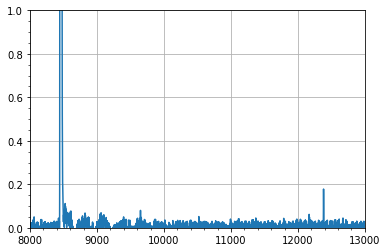

In [18]:
avg = (
    summed.loc[False, 'summed'] / summed.loc[False, 'count']
    - summed.loc[True, 'summed'] / summed.loc[True, 'count']
)
plt.plot(-avg)
plt.xlim(8000, 13000)
plt.ylim(0, 1)
plt.minorticks_on()
plt.grid(True)
plt.show()

In [5]:
def read_scala(filename):
    with File(filename, 'r') as f:
        try:
            x0 = 500
            x1 = f["/photon_diagnostics/Spectrometer/Wavelength"][...]
            a = (
                f["/photon_diagnostics/Spectrometer/WavelengthSpan"][...]
                * f["/photon_diagnostics/Spectrometer/Pixel2micron"][...]
                / 1000
            )
            _, n = f["/photon_diagnostics/Spectrometer/hor_spectrum"].shape
            x = a * (np.arange(n) - x0) + x1

            yield from ({'tag': tag,
                         'iom_intensity_pc': iom,
                         'tof_intensity': tof[8000:9000].sum(),
                         'delay': round(dt, 2),
                         'atmax': x[np.argmax(hor)]}
                        for tag, iom, tof, dt, hor
                        in zip(f['/bunches'],
                               f['/photon_diagnostics/FEL01/I0_monitor/iom_sh_a_pc'],
                               f['/digitizer/channel1'],
                               f['/user_laser/delay_line/position'],
                               f["/photon_diagnostics/Spectrometer/hor_spectrum"]))
        except KeyError:
            return


with ProgressBar():
    df = (
        from_sequence(filenames)
        .map(read_scala)
        .flatten()
        .to_dataframe()
        .compute()
    )
df

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed | 34min 43.9s


,atmax,delay,iom_intensity_pc,tag,tof_intensity
0,50.704138,-6.01,344.539833,477077530,441204
1,50.708966,-6.01,374.293900,477077531,441780
2,50.704138,-6.01,393.475342,477077532,441946
3,50.704138,-6.01,351.916122,477077533,441381
4,50.706552,-6.01,375.256920,477077534,441468
5,50.708966,-6.01,339.487839,477077535,442074
6,50.704138,-6.01,374.590874,477077536,441161
7,50.704138,-6.01,370.759392,477077537,441556
8,50.716206,-6.01,418.326759,477077538,442065
9,50.706552,-6.01,386.253548,477077539,441318


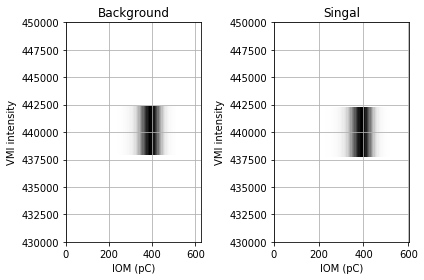

In [20]:
bg_period, bg_mod = 3, 0  # /Background_Period
df["is_bg"] = df["tag"] % bg_period == bg_mod
plt.figure()
plt.subplot(121)
where = df["is_bg"]
plt.hist2d(df[where]["iom_intensity_pc"],
           df[where]["tof_intensity"], bins=[100, 100], cmap="Greys")
plt.title("Background")
plt.xlabel("IOM (pC)")
plt.ylabel("VMI intensity")
plt.xlim(0, None)
plt.ylim(4.3e5, 4.5e5)
plt.grid(True)

plt.subplot(122)
where = ~df["is_bg"]
plt.hist2d(df[where]["iom_intensity_pc"],
           df[where]["tof_intensity"], bins=[100, 100], cmap="Greys")
plt.title("Singal")
plt.xlabel("IOM (pC)")
plt.ylabel("VMI intensity")
plt.xlim(0, None)
plt.ylim(4.3e5, 4.5e5)
plt.grid(True)
plt.tight_layout()
plt.show()

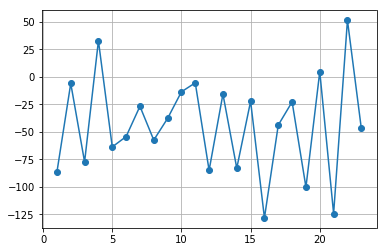

In [9]:
df['is_bg'] = df.index % bg_period == bg_mod
df["phi"] = 1239.84193 / df["atmax"] % 0.0158 / 0.0158 * 2 * np.pi
df["binned"] = df["phi"].apply(np.digitize, bins=np.linspace(0, 2 * np.pi, 24))
groupped = df.groupby(['delay', 'binned', 'is_bg'])['tof_intensity'].agg(['count', 'sum'])
diff = -(
    (groupped.loc[pd.IndexSlice[-6.01, :, False], 'sum'] / groupped.loc[pd.IndexSlice[-6.01, :, False], 'count']).reset_index(level=[0, 2], drop=True)
    - (groupped.loc[pd.IndexSlice[-6.01, :, True], 'sum'] / groupped.loc[pd.IndexSlice[-6.01, :, True], 'count']).reset_index(level=[0, 2], drop=True)
)
diff
plt.figure()
plt.plot(diff, 'o-')
#plt.ylim(0, None)
plt.grid(True)
plt.show()